---
title: "BirdClef 2023 Competition"
date: "2023-06-01"
image: "birdclef.png"
author: "Diegulio"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [Audio, code, Kaggle, Pytorch]
subtitle: "Clasificando Sonidos de Pájaros con Redes Neuronales"
---

[![](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/diegomachado/birdclef023-training-blog)

# BirdClef

En este post resolveremos un problema de audio con Machine Learning! Este es un tipo de problema que yo no había navegado anteriormente, por lo que tuve que estudiar todo sobre la teoría del sonido y como suelen resolverse estos tipos de problemas. Además aproveché de utilizar un conjunto de herramientas que es bueno saber y que personalmente quería practicar. 

El problema es bien simple, tenemos distintos archivos de sonido en donde podemos escuchar cantos de pájaros en Africa. La idea es poder detectar que tipo de pájaro está cantando! Para obtener más info del problema puedes visitar [acá](https://www.kaggle.com/c/birdclef-2023). 

Acá algunos de los conceptos/herramietas que aplicaremos:

- Audio
- Espectogramas
- Convolutional Neural Networks (CNN)
- Pytorch | Torchaudio | Pytorch Lightning
- Data Augmentation
- Weight And Biases

# Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
tqdm.pandas()
import plotly.express as px
import os
import plotly.graph_objs as go
# Audio Libraries
import librosa
import librosa.display as lid
from IPython.display import Audio

# torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchaudio import transforms as T
import torchaudio



# CFG

Acá almacenaremos la configuración del experimento, lo dividimos en distintas secciones:

- Audio Settings: Acá todo lo que tiene que ver con los parámetros de configuración para el procesamiento de los archivos de audio
- Augmentation: Parámetros para la configuración de la Data Augmentation
- Split: Configuración para la estrategia de validación
- Model: Configuración para el modelo de visión (CNN)
- Wandb: Configuración para el monitoreo del experimento
- Classes: Información de las clases de pájaros

In [2]:
class CFG:
    seed = 13
    
    # Audio Settings
    DURATION = 5 # seconds
    FRAME_SIZE = 1024 
    HOP_SIZE = 1024//2
    SAMPLE_RATE = 22050
    N_MELS = 64
    N_SAMPLES = DURATION*SAMPLE_RATE # sec * samples/sec = samples
    AUDIOS_PATH = "/kaggle/input/birdclef-2023/train_audio"
    CUT_AUDIOS_PATH = "/kaggle/input/birdclef23-audio-splits-5s"
    
    # Augmentation Settings
    FREQ_MASK_PARAM = 10
    TIME_MASK_PARAM = 25
    P_TIME_MASK = 0.5
    
    ## Mixup
    MIXUP = True
    MIXUP_CRITERION = nn.CrossEntropyLoss()
    MIXUP_LAMBDA = .8
    P_MIXUP = 0.5
    
    
    # Split
    TRAIN_SIZE = .8
    SUBSET = False # Use or not a random subsample of the dataset
    RANDOM_SUBSET = .8
    
    
    # Model
    MODEL_NAME = "tf_efficientnet_b0_ns" #"efficientnet_b0" #"tf_efficientnet_b0_ns"
    EPOCHS = 12
    WEIGHT_DECAY = 1e-3
    LR = 5e-4
    BATCH_SIZE = 32
    VAL_CHECK_INTERVAL = .5
    CHANNELS = 1 # 3
    
    # Wandb
    WANDB = True
    EXP_NAME = f"{MODEL_NAME}:V1"
    TAGS = ["SplitData", "EFNB0"]
    
    # Specific
    
    SPLIT_AUDIO = True # Using 5s audio splits
    
    # Classes 
    dirs = os.listdir(CUT_AUDIOS_PATH)
    dirs.remove('metadata.csv')
    CLASS_NAMES = sorted(dirs)
    N_CLASSES = len(CLASS_NAMES)
    CLASS_LABELS = list(range(N_CLASSES))
    label2name = dict(zip(CLASS_LABELS, CLASS_NAMES))
    name2label = {v:k for k,v in label2name.items()}

# EDA
Primero la idea es observar un poco los sonidos presentes en el dataset.

Primero enlistamos todos los archivos de audios presentes

In [3]:
# Archivos de audio
audio_samples = glob.glob('/kaggle/input/birdclef23-audio-splits-5s/*/*.ogg')

In [4]:
audio_samples[:5]

['/kaggle/input/birdclef23-audio-splits-5s/yetgre1/XC716763_0.ogg',
 '/kaggle/input/birdclef23-audio-splits-5s/yetgre1/XC344194_10.ogg',
 '/kaggle/input/birdclef23-audio-splits-5s/yetgre1/XC338717_8.ogg',
 '/kaggle/input/birdclef23-audio-splits-5s/yetgre1/XC370962_0.ogg',
 '/kaggle/input/birdclef23-audio-splits-5s/yetgre1/XC574558_1.ogg']

In [5]:
# Load Audio Data
random_audio = np.random.choice(audio_samples) # Take random audio
bird_class = random_audio.split('/')[-2] # get the class
audio_data, sampling_rate = librosa.load(random_audio) # Load audio

La data de audio es data continua, la forma de leer esta data es discretizandola, esto significa tomando samples cada cierta cantidad de segundos. Mientras la cantidad de segundos en la que tomemos cada sample sea menor, mejor será la calidad de el audio debido a que perdemos menos información. La cantidad de *samples* por segundo es llamada `sampling_rate` y se mide en Hz. Cada audio tiene su específico sample_rate, en este dataset la mayoria, si no todos, tiene un `sampling_rate=22050 Hz`, esto quiere decir que se toman **22050 samples por segundo**.

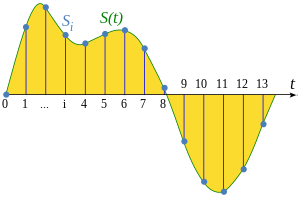

In [6]:
sampling_rate

22050

La forma en la que leemos audio en Python (y así se hace en la mayoria de casos) es obteniendo distintos samples cada segundo, en donde cada sample mide la **amplitud del sonido**. Es por esto que finalmente tenemos un array con flotantes, en donde el largo del array será la cantidad de samples que tenemos del audio.

In [7]:
# Raw Audio data
audio_data

array([ 3.2593098e-06, -2.1158910e-06,  2.6321058e-07, ...,
       -1.1784601e-03, -1.4922674e-03, -1.3934091e-03], dtype=float32)

In [8]:
# Number of samples
n_samples = len(audio_data)
n_samples

110250

En Python podemos escuchar este audio de la siguiente forma:

In [20]:
print(f'Audio of Bird {bird_class}')
Audio(audio_data, rate = sampling_rate)

Audio of Bird gargan


La forma más común de gráficar data de audio es mediante **waveplots**: Son gráficos que miden la amplitud del sonido en un tiempo determinado.

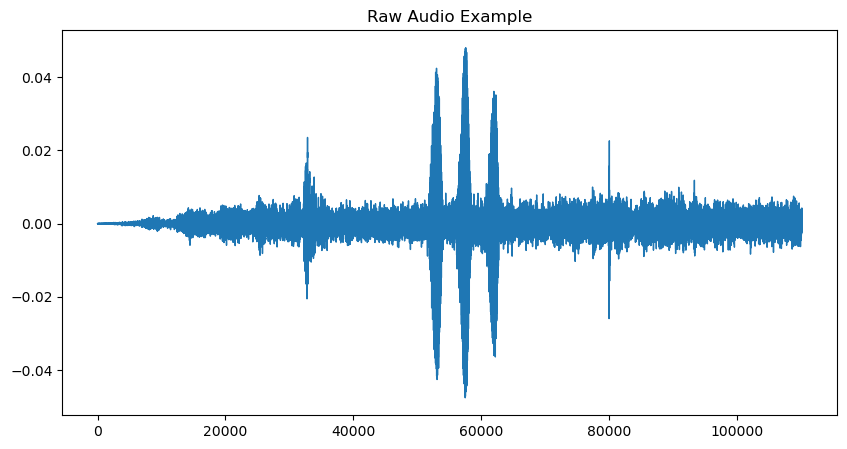

In [9]:
# Plot Audio
pd.Series(audio_data).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                  )
plt.show()

# Machine Learning en Audio Data

La pregunta sería ahora algo como: ¿Cómo puedo predecir con esta información?. 
Un pensamiento rápido podría ser mirando esto como una serie de tiempo, y así pudiendo aplicar metodologías clásicas de series de tiempo o inlcuso aplicar Deeplearning como lo son el caso de las LSTM. O incluso entregarle la información tal como está al clasificador y esperar que tengamos un buen resultado.

La verdad es que:
> La data de audio es todo sobre la evolución de los componentes de frecuencia a través del tiempo.

Existen dos features importantes para poder entender el sonido, estos son los dominios de **tiempo y frecuencia**. Si logramos entender como la frecuencia cambia a través del tiempo, podemos comprender un montón de cosas sobre el sonido.

Vamos a dividir los campos de estudio de Machine Learning en Audio en:

- **ML Tradicional**: Una forma que se suele resolver estos problemas es calcular distintas features al sonido que son del tipo Domain-Knowledge, con esto me refiero que son features relacionadas a la teoría del sonido y que son interpretables de forma intuitiva. Luego, con estas features, se aplican modelos tradicionales como Support Vector Machines, XGBoost, LightGBM, etc. Algunas de estas features son:
    - Amplitude Envelope
    - Root-mean square energy
    - Zero crossing rate
    - Band energy ratio
    
- **Deeplearning**: Esta es la forma que ha tenido mayor éxito y la más utilizada en distintos casos de uso. Lo interesante es que se busca resolver un problema de **audio** con técnicas de **vision**. ¿Por qué? Resulta que una forma de combinar información tanto de tiempo como de frecuencia, es con espectogramas. Los espectogramas son una forma **visual** de observar el cambio de la **fuerza** del sonido a través del **tiempo** a varias **frecuencias**. Entonces, como el espectograma combina información valiosa para entender el sonido, no es loco aplicar algoritmos de vision computacional para extraer los patrones presentes en ellos, es por esto que se suelen aplicar algoritmos conocidos como lo son las **Convolutional Neural Networks**.

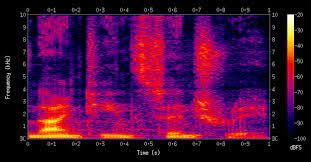



## Short Time Fourier Transform

Sabiendo ahora que lo que necesitamos es obtener espectogramas, ahora necesitamos saber como.
Para tener un espectograma, necesitamos calcular las variaciones de frecuencias a través del tiempo, por lo que necesitamos calcular frecuencias. Una metodología muy conocida en el área de matemáticas que se utiliza para esto es la **transformada de fourier**. Lamentablemente existen unos problemas al intentar aplicarla a todo un audio, es por esto que se utiliza una técnica llamada **windowing**, que lo que busca es dividir el audio en *frames* y aplicar la transformada de fourier a cada frame. Esta técnica se conoce como **Short-time Fourier Transform (STFT)**

Veamos como calcularlo:
 
La transformada de Fourier de tiempo corto (Short Time Fourier Transform o STFT) es una técnica ampliamente utilizada en el procesamiento de audio y se utiliza comúnmente en aplicaciones de aprendizaje automático. Permíteme explicarte cómo se calcula y los conceptos clave asociados.

La STFT es una forma de analizar señales de audio en dominio de frecuencia a lo largo del tiempo. Permite descomponer una señal de audio en sus componentes de frecuencia en intervalos de tiempo pequeños y consecutivos. Esto es útil para capturar información detallada sobre cómo cambian las frecuencias a lo largo del tiempo en una señal de audio.

A continuación, describiré los conceptos clave involucrados en el cálculo de la STFT:

1. Ventaneo (Windowing): El ventaneo es una técnica utilizada para evitar artefactos en la transformada de Fourier al considerar solo una sección finita de la señal a la vez. La señal de audio se multiplica por una función de ventana, que es básicamente una función que se desvanece hacia los extremos. Al multiplicar la señal por la ventana, se reduce la cantidad de energía "derramada" en las frecuencias adyacentes, lo que mejora la resolución en frecuencia. Las funciones de ventana comunes incluyen la ventana rectangular, la ventana Hamming, la ventana Blackman, entre otras.

2. Tamaño de ventana (Window Size o Frame Size): El tamaño de ventana se refiere al número de muestras de la señal de audio que se consideran para calcular la transformada de Fourier en un momento dado. Específicamente, la señal se divide en segmentos superpuestos de tamaño de ventana y se aplica la función de ventana a cada segmento. Un tamaño de ventana más grande proporciona una mejor resolución en frecuencia, pero reduce la resolución en el tiempo, mientras que un tamaño de ventana más pequeño tiene el efecto contrario.

3. Salto de ventana (Hop Size): El salto de ventana, también conocido como desplazamiento o hop size, se refiere a la cantidad de muestras que se desplaza la ventana después de calcular la transformada de Fourier para un segmento. Un salto de ventana más pequeño resulta en una mayor superposición entre los segmentos adyacentes y, por lo tanto, proporciona una mejor resolución en el tiempo. Sin embargo, también implica un mayor costo computacional. Un salto de ventana más grande reduce la superposición y aumenta la resolución en frecuencia.

El proceso general para calcular la STFT se realiza de la siguiente manera:

1. Divide la señal de audio en segmentos superpuestos de tamaño de ventana.
2. Aplica una función de ventana a cada segmento para reducir el efecto de los extremos.
3. Calcula la transformada de Fourier de cada segmento.
4. Repite los pasos anteriores desplazando la ventana por el salto de ventana hasta que se haya cubierto toda la señal de audio.

El resultado de la STFT es una matriz 2D que representa la magnitud o la fase de las componentes de frecuencia a lo largo del tiempo. Esta matriz se puede utilizar posteriormente en técnicas de aprendizaje automático, como redes neuronales, para extraer características o para realizar tareas específicas, como clasificación de audio, detección de eventos,entre otras.

En resumen, la STFT es una herramienta poderosa en el procesamiento de audio y el aprendizaje automático. Permite analizar las características de frecuencia que cambian en el tiempo en una señal de audio y se calcula mediante el ventaneo de la señal, el cálculo de la transformada de Fourier en cada segmento y el desplazamiento de la ventana a lo largo de la señal.

In [10]:
# Seteamos el tamaño del frame (en cantidad de samples) y el tamaño del HOP
FRAME_SIZE = 1024
HOP_SIZE = FRAME_SIZE//2

In [11]:
# Utilizamos librosa para aplicar stft
s_audio = librosa.stft(audio_data, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [12]:
s_audio.shape #(frequency bins, frames) # Complex numbers

(513, 216)

In [13]:
FRAME_SIZE//2 + 1, (n_samples + FRAME_SIZE)//HOP_SIZE + 1

(513, 218)

La técnica STFT nos entrega números complejos, para poder entenderlos e ingresarlos a un modelo de machine learning, calculamos su magnitud

In [14]:
# We get the magnitude 
m_audio = np.abs(s_audio)**2

¿Como observamos de otra forma un audio? 

Un espectrograma es una representación visual que muestra cómo varía la energía espectral de una señal a lo largo del tiempo. Muestra cómo se distribuyen las diferentes frecuencias en una señal en función del tiempo. En un espectrograma convencional, la amplitud de las frecuencias se representa mediante colores o tonos de grises, donde los colores más brillantes o más claros indican una mayor amplitud y los colores más oscuros indican una menor amplitud.

Con esto, ahora podemos observar los siguientes espectogramas:

In [15]:
# Plot Spectogram
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    """
    Plot a spectrogram of an audio signal.

    Parameters:
    - Y (ndarray): 2D array representing the spectrogram.
    - sr (int): Sampling rate of the audio signal.
    - hop_length (int): Number of samples between successive frames.
    - y_axis (str, optional): Scale of the frequency axis. Default is "linear".

    Returns:
    None

    This function plots a spectrogram of the audio signal using the provided parameters. The spectrogram represents
    the distribution of frequencies over time.

    Example usage:
    >>> plot_spectrogram(Y, sr=22050, hop_length=512, y_axis="log")

    """
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

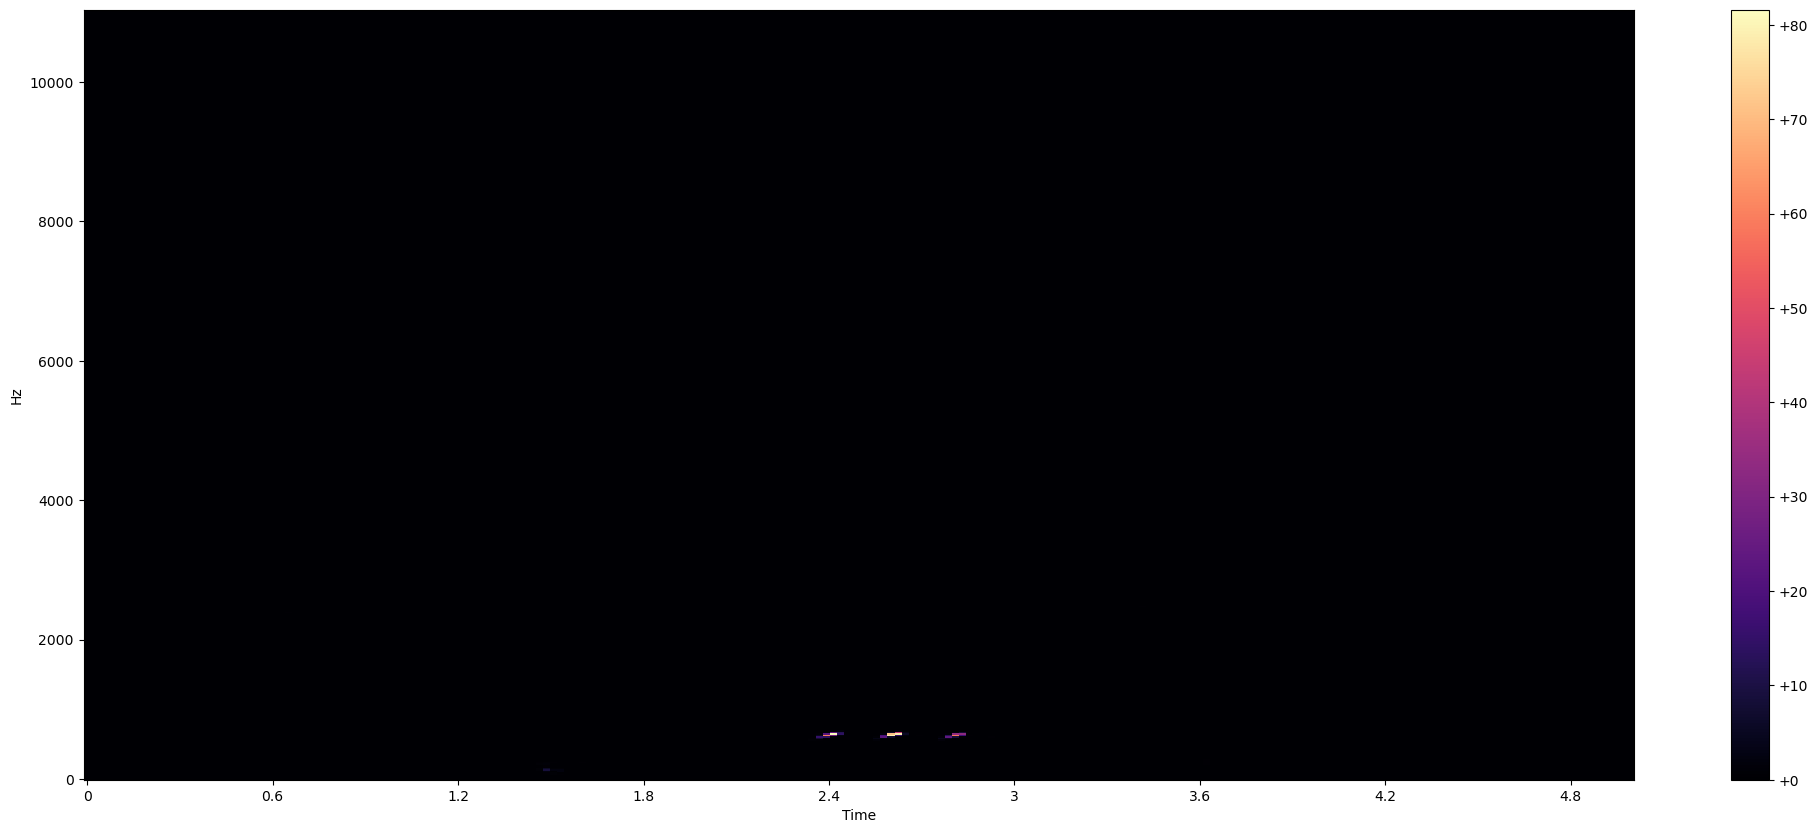

In [16]:
plot_spectrogram(m_audio, sampling_rate, HOP_SIZE)

Podemos notar que las frecuencias son muy bajas, para poder observarlo de mejor forma, calculamos el logaritmo, lo que equivale a transformar el sonido a decibeles (algo que los humanos podemos entender).

## Log-Amplitud Spectogram


Por otro lado, un espectrograma de amplitud logarítmica (Log-Amplitude Spectrogram) aplica una transformación logarítmica a la amplitud de las frecuencias antes de su representación visual. En lugar de mostrar la amplitud directamente, se muestra el logaritmo de la amplitud. Esto se hace para mejorar la interpretación visual y resaltar mejor las características de baja amplitud en la señal.

Existen varias razones por las que se utiliza un espectrograma de amplitud logarítmica en lugar de un espectrograma normal:

Escala perceptual: La audición humana no percibe la amplitud de manera lineal, sino de forma logarítmica. Al aplicar la transformación logarítmica, el espectrograma de amplitud logarítmica se ajusta más a cómo percibimos el sonido, lo que facilita su interpretación.

Rango dinámico: El uso de una escala logarítmica comprime el rango dinámico del espectrograma. Esto significa que las diferencias de amplitud más pequeñas se vuelven más visibles y fáciles de distinguir, lo que permite apreciar mejor las características de baja amplitud en la señal.

Reducción de ruido: Al aplicar una transformación logarítmica, las partes más ruidosas de la señal se atenúan, lo que ayuda a reducir la presencia visual del ruido y mejora la legibilidad del espectrograma.


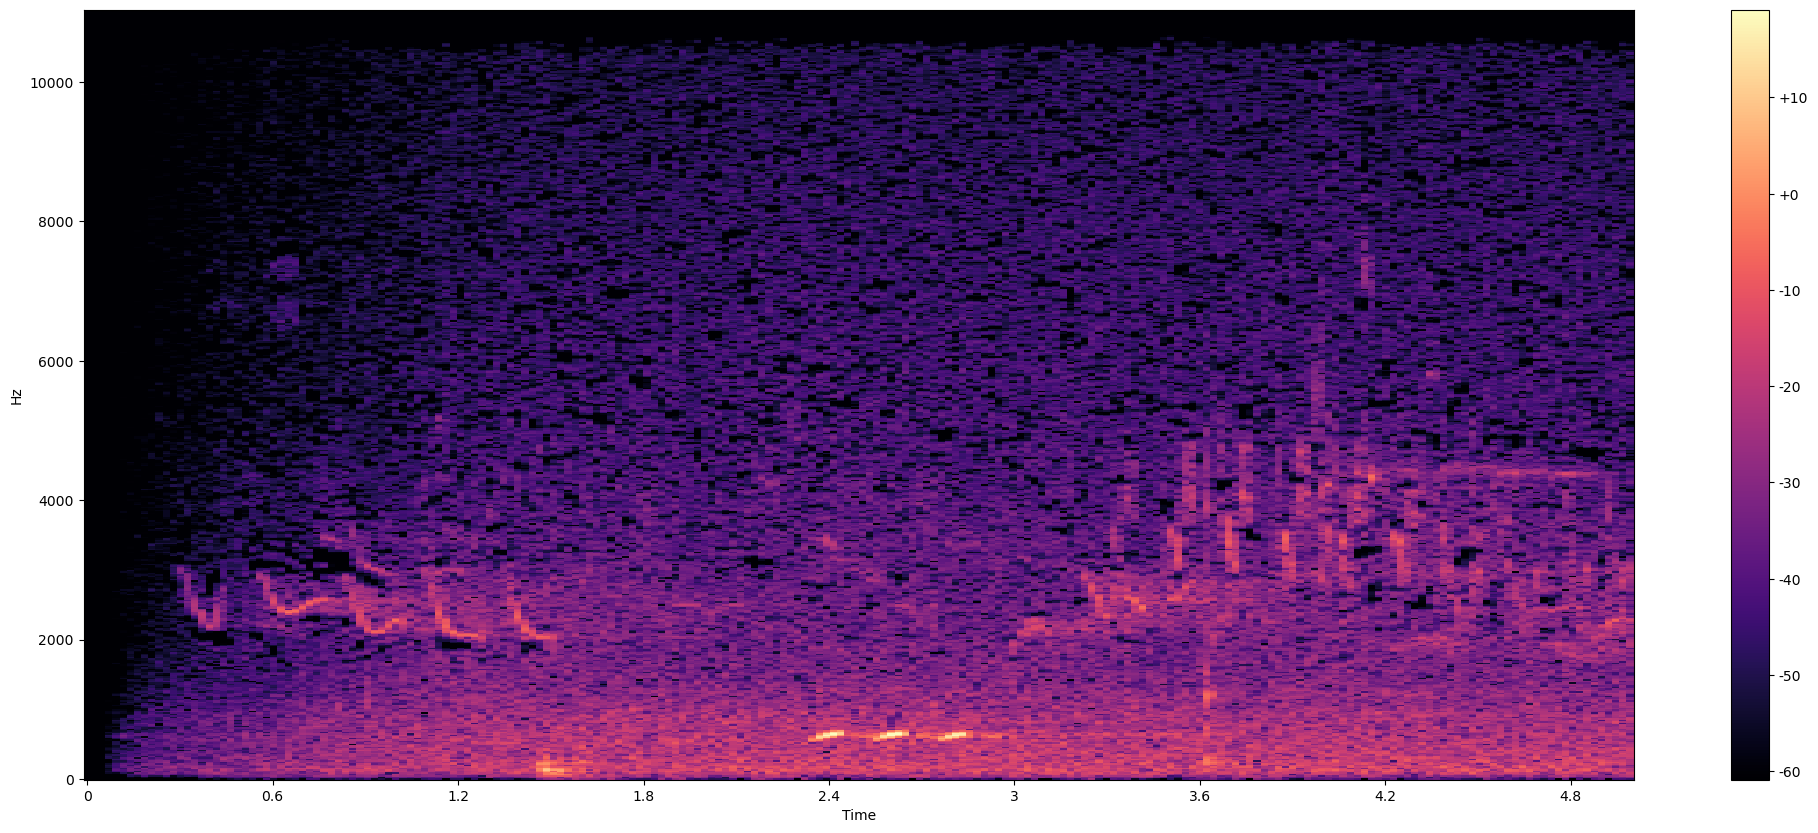

In [17]:
# To a better visualization, we obtain logs (transform to decibels)

Y_log_scale = librosa.power_to_db(m_audio)
plot_spectrogram(Y_log_scale, sampling_rate, HOP_SIZE)

## Log-Frequency Spectogram

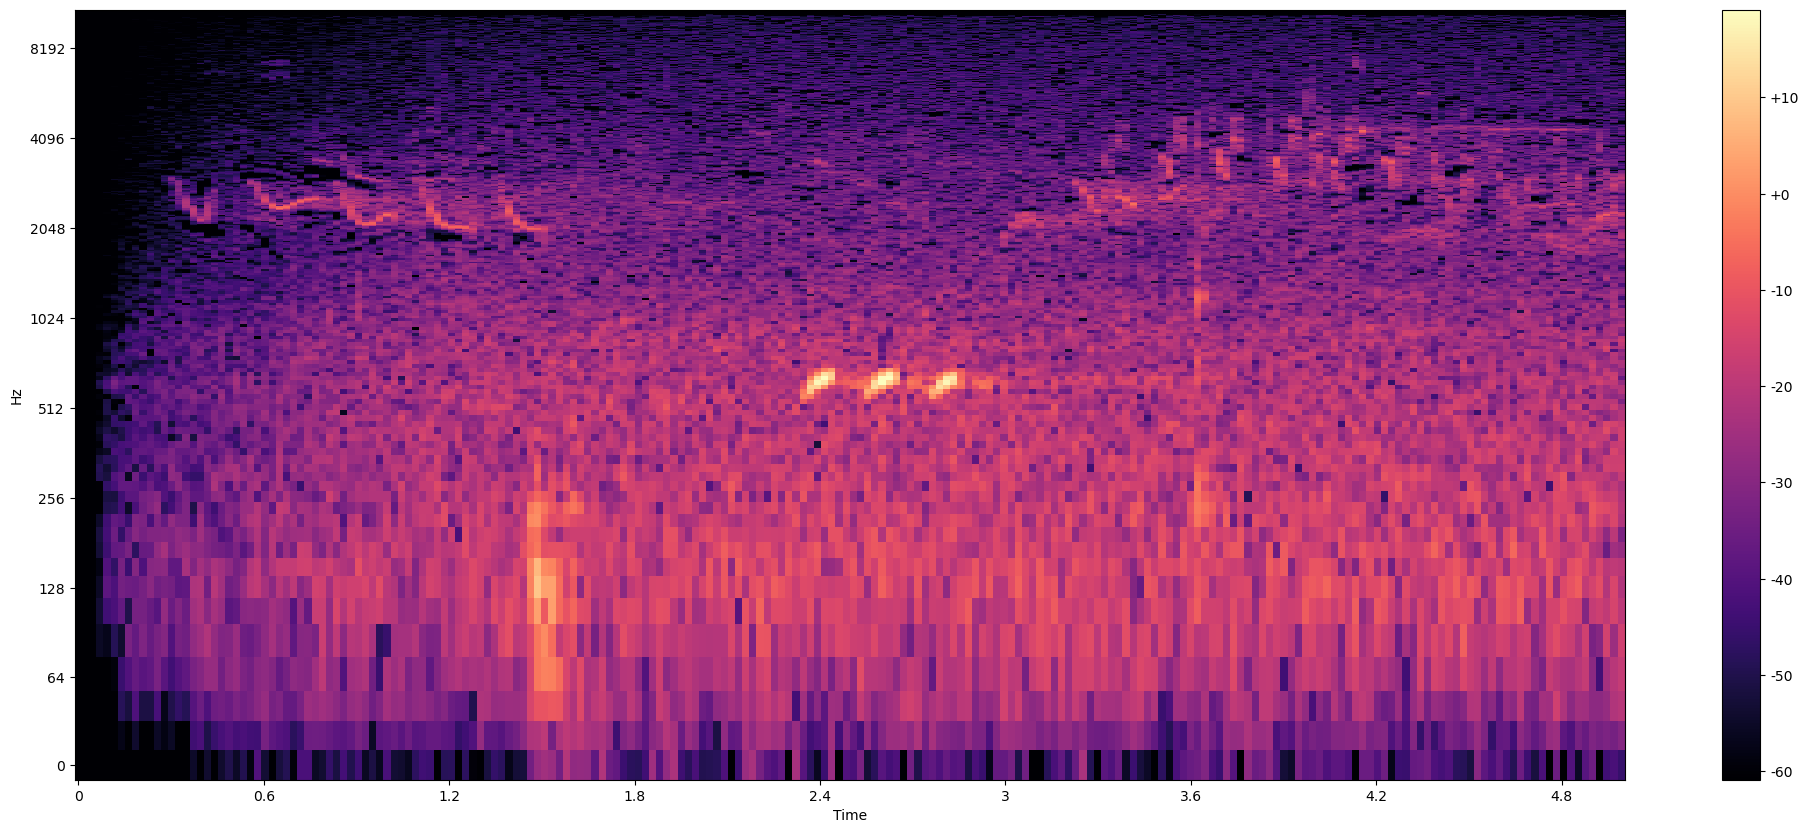

In [18]:
# Now we also put the log in the Y-axis (frequency)
plot_spectrogram(Y_log_scale, sampling_rate, HOP_SIZE, y_axis="log")

¿ Como se obtienen los espectogramas?

 El cálculo de un espectrograma implica varios pasos:

1. Preprocesamiento de la señal: Si la señal de audio no está en el dominio del tiempo discreto, se debe convertir a ese formato. Además, es posible que desees aplicar técnicas de preprocesamiento adicionales, como normalización o eliminación de ruido, para mejorar la calidad del espectrograma.

2. División de la señal en segmentos: La señal de audio se divide en segmentos superpuestos de longitud fija. La longitud de estos segmentos se denomina "ventana" y es un parámetro importante en el cálculo del espectrograma. La elección de la longitud de la ventana depende de la resolución temporal y frecuencial deseada. Una ventana típicamente utilizada es la ventana de Hamming.

3. Aplicación de la función de ventana: A cada segmento de la señal se le aplica una función de ventana, como la ventana de Hamming mencionada anteriormente. La función de ventana reduce las discontinuidades en los extremos de los segmentos y ayuda a evitar el sangrado espectral (spectral leakage), que puede introducir artefactos no deseados en el espectrograma.

4. Cálculo de la Transformada de Fourier de tiempo corto (STFT): Para cada segmento de la señal, se calcula la Transformada de Fourier de tiempo corto (STFT). La STFT se obtiene aplicando la Transformada de Fourier a cada segmento de la señal después de aplicar la función de ventana. La STFT proporciona información sobre la distribución de frecuencias en cada segmento de tiempo.

5. Cálculo del espectrograma: El espectrograma se crea a partir de la magnitud cuadrada de los valores obtenidos en la STFT. La magnitud cuadrada se calcula para resaltar las amplitudes y eliminar la información de fase. Luego, se aplica una escala de colores o una escala de grises para representar la amplitud de cada frecuencia en función del tiempo. Los valores más altos de amplitud se suelen representar con colores más brillantes o tonos de grises más claros, mientras que los valores más bajos se representan con colores más oscuros o tonos de grises más oscuros.

Es importante tener en cuenta que los parámetros utilizados en el cálculo del espectrograma, como el tamaño de la ventana y el solapamiento de los segmentos, pueden afectar la resolución temporal y frecuencial del espectrograma resultante. Por lo tanto, es posible que debas ajustar estos parámetros según las necesidades específicas de tu aplicación.


# Metadata

Los archivos de audio en esta competencia vienen con metadata (información extra). Es importante utilizar esta información extra a la hora de entrenar los modelos, o de hacer distintos procesamiento. En este caso no los utilicé porque mi objetivo no era obtener un buen lugar, si no poder aprender a como resolver este tipo de problemas. Lo que haremos, será analizar la cantidad de audios por cada tipo de pájaros, para tener una idea del balanceo de los datos.

In [19]:
original_metadata = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')
original_metadata.head()

primary_label secondary_labels              type  latitude  longitude  \
0       abethr1               []          ['song']    4.3906    38.2788   
1       abethr1               []          ['call']   -2.9524    38.2921   
2       abethr1               []          ['song']   -2.9524    38.2921   
3       abethr1               []          ['song']   -2.9524    38.2921   
4       abethr1               []  ['call', 'song']   -2.9524    38.2921   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
2  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
3  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
4  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.0   
1  Creative Commons Attribution-NonCommercial-Sha...     3.5   
2  Creative Commons Attribution-NonCommercial-Sha...     3.5   
3  Creative Commons Attribution-NonCommercial-Sha...     5.0   
4  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                 url              filename  
0  https://www.xeno-canto.org/128013  abethr1/XC128013.ogg  
1  https://www.xeno-canto.org/363501  abethr1/XC363501.ogg  
2  https://www.xeno-canto.org/363502  abethr1/XC363502.ogg  
3  https://www.xeno-canto.org/363503  abethr1/XC363503.ogg  
4  https://www.xeno-canto.org/363504  abethr1/XC363504.ogg

In [20]:
metadata = pd.read_csv('/kaggle/input/birdclef23-audio-splits-5s/metadata.csv')
metadata.head()

primary_label secondary_labels      type  latitude  longitude  \
0       abethr1               []  ['song']    4.3906    38.2788   
1       abethr1               []  ['song']    4.3906    38.2788   
2       abethr1               []  ['song']    4.3906    38.2788   
3       abethr1               []  ['song']    4.3906    38.2788   
4       abethr1               []  ['song']    4.3906    38.2788   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
2  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
3  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
4  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.0   
1  Creative Commons Attribution-NonCommercial-Sha...     4.0   
2  Creative Commons Attribution-NonCommercial-Sha...     4.0   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0   
4  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                 url                filename  
0  https://www.xeno-canto.org/128013  abethr1/XC128013_0.ogg  
1  https://www.xeno-canto.org/128013  abethr1/XC128013_1.ogg  
2  https://www.xeno-canto.org/128013  abethr1/XC128013_2.ogg  
3  https://www.xeno-canto.org/128013  abethr1/XC128013_3.ogg  
4  https://www.xeno-canto.org/128013  abethr1/XC128013_4.ogg

### Metadata EDA

In [21]:
print(f'original metadata length: {len(original_metadata)}')
print(f'New metadata length: {len(metadata)}')

original metadata length: 16941
New metadata length: 131191


In [22]:
fig = px.histogram(original_metadata, x="primary_label", nbins=len(original_metadata["primary_label"].unique()))
fig.update_layout(title_text="Distribution of Primary Labels")
fig.show()

In [36]:
fig = px.histogram(metadata, x="primary_label", nbins=len(metadata["primary_label"].unique()))
fig.update_layout(title_text="Distribution of Primary Labels")
fig.show()

# Prototyping


In [37]:
from torch.utils.data import Dataset, DataLoader
import os
import torchaudio
import torch

In [38]:
CFG.N_SAMPLES

110250

## Train, Val SPlit

Existe un concepto en Machine Learning muy importante llamado "overfitting", que básicamente es cuando los modelos comienzan a aprenderse de memoria los datos en vez de buscar patrones que puedan funcionar bien para predecir a futuro. Es por esto que una de las acciones que se toman para evitar el overfitting es un "split" de la data. Esto es, simplemente dividimos la data en dos partes (o en 3), una parte llamada de **entrenamiento** y otra llamada de **prueba**. Así entrenamos nuestro modelo en la data de entrenamiento y luego calculamos métricas en la parte de prueba para así tener con mayor certeza una aproximación de como nuestro modelo lo hará para datos que no fueron vistos a la hora de entrenar. El splitting es mucho más complicado que esto, pero con esto se tiene una idea.


Ya que dividimos los audios, tenemos que asegurarnos que todos los splits de un mismo audio esten o en train o en test, para no generar leakages. 

### Original Metadata

In [25]:
original_metadata

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16936       yewgre1               []              ['']   -1.2502    29.7971   
16937       yewgre1               []              ['']   -1.2489    29.7923   
16938       yewgre1               []              ['']   -1.2433    29.7844   
16939       yewgre1               []              ['']    0.0452    36.3699   
16940       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_name                common_name          author  \
0        Turdus tephronotus   African Bare-eyed Thrush   Rolf A. de By   
1        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
2        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
3        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
4        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
...                     ...                        ...             ...   
16936  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16937  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16938  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16939  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   
16940  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
16936  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16937  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16938  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16939  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16940  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                     url              filename  
0      https://www.xeno-canto.org/128013  abethr1/XC128013.ogg  
1      https://www.xeno-canto.org/363501  abethr1/XC363501.ogg  
2      https://www.xeno-canto.org/363502  abethr1/XC363502.ogg  
3      https://www.xeno-canto.org/363503  abethr1/XC363503.ogg  
4      https://www.xeno-canto.org/363504  abethr1/XC363504.ogg  
...                                  ...                   ...  
16936      https://xeno-canto.org/703472  yewgre1/XC703472.ogg  
16937      https://xeno-canto.org/703485  yewgre1/XC703485.ogg  
16938      https://xeno-canto.org/704433  yewgre1/XC704433.ogg  
16939      https://xeno-canto.org/752974  yewgre1/XC752974.ogg  
16940      https://xeno-canto.org/753190  yewgre1/XC753190.ogg  

[16941 rows x 12 columns]

In [26]:
# Contamos los audios para cada pajaro
m_count = original_metadata.primary_label.value_counts()
one_class = list(m_count[m_count <= 1].index)
# Aseguramos aquellos pajaros que si o si estarán en el entrenamiento (sólo tienen un dato)
to_train = original_metadata[original_metadata.primary_label.isin(one_class)].copy()
metadata = original_metadata[~original_metadata.primary_label.isin(one_class)].copy()

In [27]:
# Hacemos el split
from sklearn.model_selection import train_test_split
metadata_train, metadata_test = train_test_split(metadata, train_size = CFG.TRAIN_SIZE, random_state=CFG.seed, stratify = metadata['primary_label'])

In [28]:
# Le agregamos aquellos pajaros que deben ir en el entrenamiento
metadata_train = pd.concat([metadata_train, to_train], axis = 0)

In [29]:
# Guardamos los datos
metadata_train.to_csv('train_metadata.csv', index = False)
metadata_test.to_csv('val_metadata.csv', index = False)

## MelSpectograms + EfficientNet

Como mencionamos anteriormente, la metodología más comun para clasificar audios es tratar el problema como un de **visión**. En donde la imágen que queremos procesar está dada por un espectograma. En este caso utilizaremos una variación llamada **MelSpectogram**.

El modelo clasificador, será el modelo ya pre-entrenado llamado EfficientNet. El motivo de esto es que según comentarios de otros competidores, este modelo funciona bien en este tipo de data (Audios de pájaros). Existen distintos repositorios en donde podemos encontrar estos modelos pre-entrenados (Tensorflow Hub, Pytorch Hub, timm, etc.). En este caso usaré timm ¿Por qué? Simplemente porque había oído de el y quice probarlo. 

### Timm
El framework de aprendizaje automático timm (Transfer Image Models) es una biblioteca de código abierto que proporciona una amplia colección de modelos preentrenados y herramientas para la visión por computadora

### EfficientNet

EfficientNet es un modelo de red neuronal convolucional desarrollado por Google que destaca por su eficiencia y rendimiento sobresaliente en la clasificación de imágenes. Utiliza un enfoque de escalado compuesto, ajustando la profundidad, el ancho y la resolución de la imagen de entrada de manera óptima. Esto le permite lograr un equilibrio entre el tamaño de la red y el rendimiento, superando a modelos anteriores y siendo altamente eficiente en el uso de recursos computacionales y memoria.

### MelSpectogram

Un mel spectrograma, o melspectrograma, es una representación visual que muestra cómo varía la energía espectral de una señal de audio en función del tiempo y de las bandas de frecuencia mel. El melspectrograma es una versión modificada del espectrograma convencional que utiliza una escala de frecuencia perceptualmente más relevante, conocida como escala mel.

La escala mel es una escala no lineal que se basa en la percepción humana de las frecuencias de sonido. Esta escala asigna más resolución a las frecuencias más bajas, donde nuestro sistema auditivo es más sensible, y menos resolución a las frecuencias más altas.

El proceso de cálculo de un melspectrograma implica los siguientes pasos:

1. Preprocesamiento de la señal: Al igual que con el cálculo de un espectrograma, se pueden aplicar técnicas de preprocesamiento a la señal de audio, como conversión al dominio del tiempo discreto y normalización.

2. División de la señal en segmentos: La señal de audio se divide en segmentos superpuestos de longitud fija, al igual que en el cálculo del espectrograma.

3. Aplicación de la función de ventana: A cada segmento de la señal se le aplica una función de ventana, como la ventana de Hamming, para reducir las discontinuidades en los extremos de los segmentos y evitar el sangrado espectral.

4. Cálculo de la Transformada de Fourier de tiempo corto (STFT): Se calcula la STFT para cada segmento de la señal después de aplicar la función de ventana. La STFT proporciona información sobre la distribución de frecuencias en cada segmento de tiempo.

5. Conversión a la escala mel: Los coeficientes de frecuencia obtenidos de la STFT se convierten a la escala mel utilizando una transformación no lineal. Esta transformación se basa en filtros mel, que se superponen en el dominio de la frecuencia para representar las bandas de frecuencia mel.

6. Cálculo del melspectrograma: El melspectrograma se crea a partir de la magnitud cuadrada de los valores obtenidos en el paso anterior. Luego, se aplica una escala de colores o una escala de grises para representar la amplitud de cada banda de frecuencia mel en función del tiempo.

En resumen, un melspectrograma es una representación visual que muestra cómo varía la energía espectral de una señal de audio en función del tiempo y de las bandas de frecuencia mel. Se calcula mediante la conversión de los coeficientes de frecuencia obtenidos de la STFT a la escala mel y representa la amplitud de cada banda de frecuencia mel en función del tiempo utilizando una escala de colores o de grises.

In [38]:
def get_sample():
    audio_samples = glob.glob('/kaggle/input/birdclef-2023/train_audio/*/*.ogg')
    random_audio = np.random.choice(audio_samples)
    bird_class = random_audio.split('/')[-2]
    #signal, sampling_rate = librosa.load(random_audio)
    signal, sampling_rate  = torchaudio.load(random_audio)
    return signal, sampling_rate

def plot_waveform(signal, sr):
    # Plot the waveform
    plt.figure(figsize=(15, 5))
    lid.waveshow(signal.numpy(), sr=sr)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()
    
def display_audio(signal, sr):
    return Audio(signal, rate = sr)

def get_mel_spectogram(signal, sr):
    mel_t = T.MelSpectrogram(sample_rate = sr, n_fft = CFG.FRAME_SIZE,
                            hop_length = CFG.HOP_SIZE, n_mels = CFG.N_MELS)
    mel = mel_t(signal).squeeze(0)
    return mel

# Plot Spectogram
def plot_spectrogram(mel, sr, hop_length, scaled = False):
    if not scaled:
        # Convert to dB scale (log-scale)
        mel = librosa.power_to_db(mel, ref=np.max)
        
    # Plot the mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, x_axis='time',
                             y_axis='mel', sr=sr, hop_length=CFG.HOP_SIZE)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

    
    


In [40]:
sample, sr = get_sample()

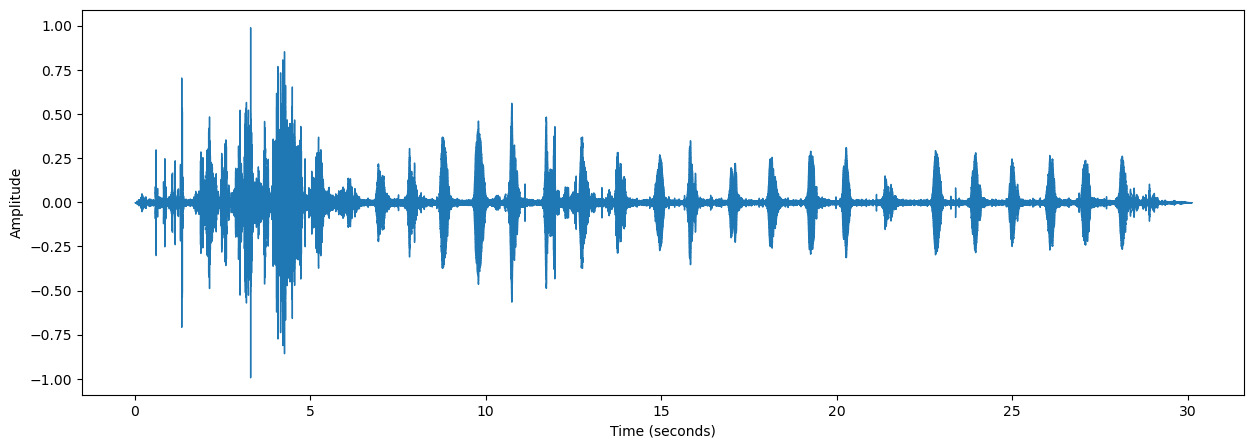

In [41]:
plot_waveform(sample, sr)

In [42]:
mel = get_mel_spectogram(sample, sr)

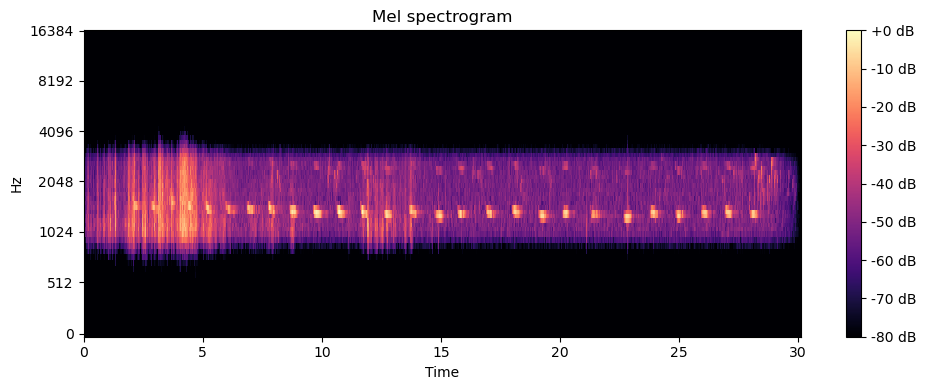

In [43]:
plot_spectrogram(mel, sr, CFG.HOP_SIZE, scaled = False)

## Data Augmentation

Otro concepto importante que sería bueno conocer, esta vez en DeepLearning, es `Data Augmentation`. Como su nombre lo dice, este busca aumentar los datos de forma sintétinca. 

**¿Por qué?** En ML siempre es bueno tener más datos, podemos ver los datos como experiencia, a mayor experiencia, mayor conocimiento tenemos.

**¿Cómo?** En visión existen distintos tipos de Data Augmentation, por ejemplo, tomar algunos de los datos que ya tenemos y girarlos aleatoriamente, o quizá cortalos, o quizás hacerles un zoom, etc. En este caso, las técnicas tradicionales de Data Augmentation en visión no son útiles porque no tienen sentido o no son interpretables ¿ Que significa que haga un zoom a un espectograma? O que lo gire 90 grados? 

En este caso aplicaremos dos tipos de Data Augmentation:

1. **Signal Data Augmentation**: Buscamos aplicarle ciertos efectos al audio en si
2. **Spectogram Augmentation**: Utilizaremos algunas técnicas que si tengan sentido cuando trabajamos con Audio. 

### MixUp 
Más adelante veremos otra técnica llamada MixUp.

In [45]:
class ComposeTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, audio_data):
        for t in self.transforms:
            audio_data = t(audio_data)
        return audio_data



### Signal Augmentations

### Gaussian Noise:

Gaussian Noise en el procesamiento de audio es un tipo de ruido aleatorio que se utiliza para simular ruidos ambientales y evaluaciones de calidad del sonido. Se genera agregando valores aleatorios extraídos de una distribución normal a la señal de audio original. Además, se utiliza como técnica de regularización en el entrenamiento de modelos de aprendizaje automático. Su aplicación implica agregar variabilidad y evaluar el impacto del ruido en la señal de audio.

In [48]:
import random

In [49]:
class GaussianNoise:
    def __init__(self, mean = 0, sigma = 'auto', p = 0.5):
        self.mean = mean
        self.sigma = sigma
        self.p = p
        
    def __call__(self, audio):
        random_f = torch.rand([]).item()
        
        if self.sigma == 'auto':
            sigma = audio.std()
        else:
            sigma = self.sigma
    
        if self.p < random_f:

            std_dev = random.uniform(0, sigma)
            noise = torch.randn_like(audio) * std_dev + self.mean

            # Add the noise to the audio signal
            audio = audio + noise
    
        return audio
        

In [50]:
gaussian_noise = GaussianNoise()

In [54]:
noise_sample = gaussian_noise(sample)

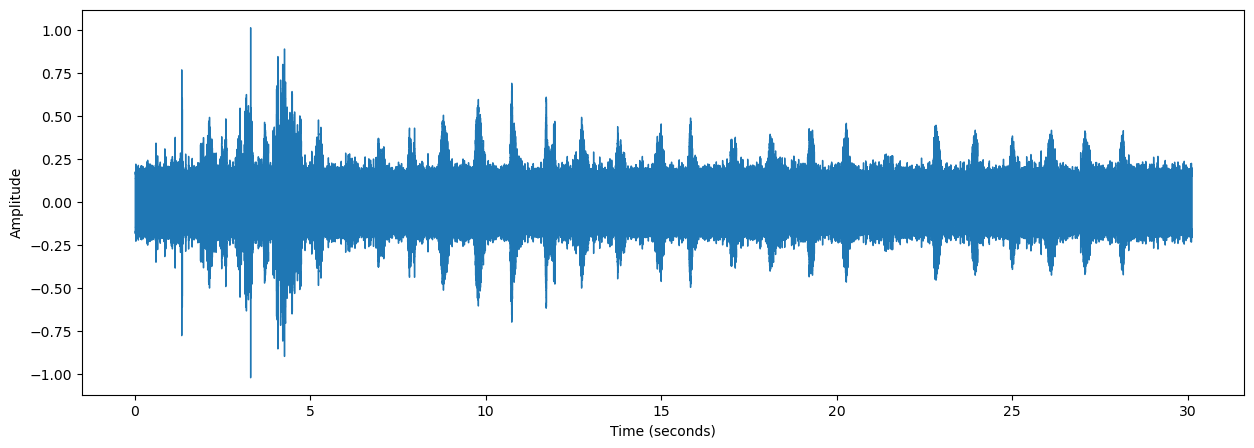

In [55]:
plot_waveform(noise_sample, sr)

In [56]:
display_audio(sample, sr)

In [57]:
display_audio(noise_sample, sr)

In [58]:
signal_augmentations = ComposeTransform([
    GaussianNoise()
])


### Spectogram Augmentations

### Frequency Masking

FrequencyMasking es una técnica utilizada en el procesamiento de audio para eliminar o enmascarar información de frecuencia específica en una señal de sonido. Funciona al "mascarar" o bloquear un rango de frecuencias en el espectro de audio. Esto se logra aplicando un filtro que atenúa o elimina selectivamente las componentes de frecuencia dentro del rango especificado. Al enmascarar ciertas frecuencias, se pueden ocultar características no deseadas o mejorar la detección de otras características importantes en la señal de audio. Esta técnica es comúnmente utilizada en tareas de reconocimiento de voz, separación de fuentes de audio y reducción de ruido para mejorar la calidad y el rendimiento de los algoritmos de procesamiento de audio.

### TimeMasking

TimeMasking es una técnica utilizada en el procesamiento de audio para enmascarar o bloquear segmentos de tiempo específicos en una señal de sonido. Consiste en ocultar o atenuar temporalmente ciertas partes de la señal de audio, creando una especie de "máscara" en el dominio del tiempo. Al aplicar TimeMasking, se bloquea temporalmente la información de sonido dentro de un intervalo de tiempo determinado. Esta técnica es útil para ocultar partes no deseadas de la señal, mejorar la privacidad de la información o enfocar la atención en partes específicas del audio. Es ampliamente utilizado en tareas como el procesamiento de voz, reconocimiento de habla y análisis de señales de audio en general.

### Data Augmentation
Básicamente puedes imaginar un masking de forma horizontal y vertical si lo vemos en un espectograma


In [59]:
spec_augmentations = nn.Sequential(
    T.FrequencyMasking(CFG.FREQ_MASK_PARAM),
    T.TimeMasking(time_mask_param = CFG.TIME_MASK_PARAM, p = CFG.P_TIME_MASK)
)

In [60]:
augm_spec = spec_augmentations(mel[None, ...])

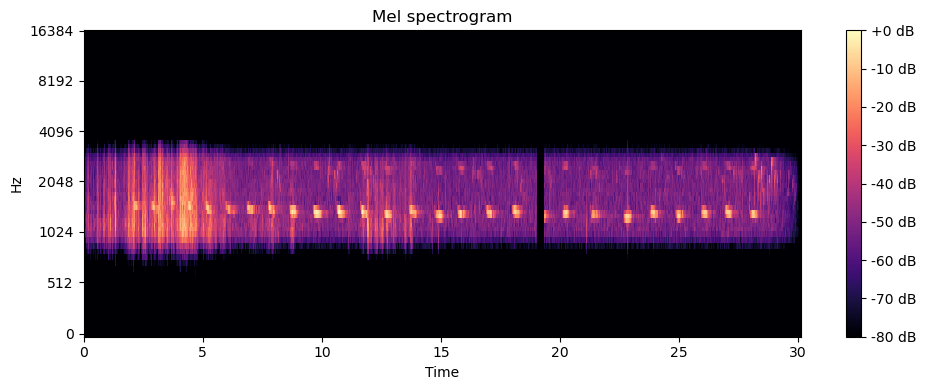

In [61]:
plot_spectrogram(augm_spec.squeeze(0), sr, CFG.HOP_SIZE, scaled = False)

## Load Data

En este caso de uso, haremos uso de Pytorch Lighting, que es un framework basado en Pytorch. 
En cualquier framework que decidamos utilizar se debe crear un script para cargar los datos. En el caso de Pytorch creamos una clase que debe tener ciertos requisitos:

- \_\_len__
- \_\_getitem__

En este caso, incorporé la creación de MelSpectograms, para crear cada instancia entonces realizo:
1. Obtener el path del audio correspondiente
2. Leer el audio utilizando torchaudio
3. Resample: la idea es que todos los sonidos tengan la misma "resolución", por esto resampleamos cada audio
4. Mix Down: Dejamos el audio con un sólo canal: stereo -> mono
5. Cut: Ya que existen audios que tienen diferentes largos, cortamos 5 segundos aleatorios de cada uno. En caso de ser validación, tomamos los primeros 5 segundos del audio, esto debido a que la data de validación debe ser la misma en cada epoch.
6. Signal Augmentations: Aplicamos Data Augmentation para señales
7. MelSpectograms: Obtenemos los MelSpectogramas
8. Pasamos la escala a decibeles, lo hace más "entendible"
9. Spectograms Augmentations: Aplicamos Data Augmentation para spectogramas
10. Para crear imagenes con 3 canales, repetimos el spectograma
11. Target Transform: ya que el target debe ser numérico, hacemos esta transformación.

In [ ]:
class BirdDataset(Dataset):
     """
    Dataset class for bird audio classification.

    Parameters:
    - metadata_path (str): Path to the metadata CSV file.
    - audio_path (str): Path to the directory containing the audio files.
    - sr (int, optional): Sampling rate of the audio files. Default is CFG.SAMPLE_RATE.
    - framesize (int, optional): Size of the audio frames. Default is CFG.FRAME_SIZE.
    - hop (int, optional): Number of samples between successive frames. Default is CFG.HOP_SIZE.
    - n_mels (int, optional): Number of mel bands in the mel spectrogram. Default is CFG.N_MELS.
    - n_samples (int, optional): Number of samples to be used from each audio file. Default is CFG.N_SAMPLES.
    - signal_augmentations (callable, optional): Function or transform to apply signal augmentations. Default is None.
    - spec_augmentations (callable, optional): Function or transform to apply spectrogram augmentations. Default is None.
    - train (bool, optional): Whether the dataset is for training or not. Default is True.

    Methods:
    - __len__(): Returns the number of samples in the dataset.
    - __getitem__(idx): Retrieves a sample from the dataset.

    """
    def __init__(self, metadata_path, audio_path, sr = CFG.SAMPLE_RATE,
                 framesize = CFG.FRAME_SIZE, hop = CFG.HOP_SIZE,
                 n_mels = CFG.N_MELS, n_samples = CFG.N_SAMPLES, 
                 signal_augmentations = None, spec_augmentations = None, train = True):
        """
        Initialize the BirdDataset.

        Loads the metadata CSV file, sets the audio paths and parameters, and defines augmentations.

        """
        
        self.metadata = pd.read_csv(metadata_path)
        self.audio_path = audio_path
        self.framesize = framesize
        self.hop = hop
        self.sr = sr
        self.n_mels = n_mels
        self.num_samples = n_samples
        self.signal_augmentations = signal_augmentations
        self.spec_augmentations = spec_augmentations
        self.train = train
        
    
        
    
    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
        - int: Number of samples.

        """
        return len(self.metadata)
    
    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset.

        Parameters:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - tuple: A tuple containing the mel spectrogram and the target label.

        """
        # 1. Get image path and label
        path, label = self.metadata.loc[idx, ["filename", "primary_label"]]
        full_path = os.path.join(self.audio_path, path)
        
        # 2. Load audio
        waveform, sample_rate = torchaudio.load(full_path)
        
        
        
        # 3. & 4. preprocess
        waveform = self._resample(waveform, sample_rate)
        waveform = self._mix_down(waveform)
        
        #5. Cut or take first
        if not(CFG.SPLIT_AUDIO):
            if self.train:
                waveform = self._random_cut(waveform) # Get random split if > duration
            else:
                waveform = self._take_first(waveform) # Get the first split (Validation should not be random)

            waveform = self._pad(waveform)
        
        #6. Signal Augmentations
        if self.signal_augmentations != None:
            waveform = self.signal_augmentations(waveform)
            

        
        #7. MelSpectogram
        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate = self.sr, n_fft = self.framesize,
                                                             hop_length = self.hop, n_mels = self.n_mels)
        mels = mel_transform(waveform)
        
        #8. To decibels
        to_db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)
        mels = to_db(mels)
        
        #9. Spectogram Augmentations
        if self.spec_augmentations != None:
            mels = self.spec_augmentations(mels)
            
        # ride off the batch
        mels = mels.squeeze(0)
    
        #10. Stack (Add channels in based in efffnet requirements)
        if CFG.CHANNELS==3:
            mels = torch.stack([mels,mels, mels], dim=0)
        else:
            mels = mels[None, :, :]
        
       
        
        # 11. Label transform (OHE)
        num_label = CFG.name2label[label]
        target = F.one_hot(torch.tensor(num_label), num_classes = CFG.N_CLASSES)
        target = target.type(torch.FloatTensor)
        
        return mels, target
    
    
    #### Helper Functions #####
    
    def _random_cut(self, signal):
        """
        Randomly cut a segment from the given signal.

        Parameters:
        - signal (Tensor): Input signal.

        Returns:
        - Tensor: Cut segment of the signal.

        """
        if signal.shape[1] > self.num_samples:
            #signal = signal[:, :self.num_samples]
            diff_len = signal.shape[1] - self.num_samples 
            idx = int(torch.rand([]).item()*diff_len)
            signal = signal[:, idx: (idx + self.num_samples)]
        return signal
    
    
    def _take_first(self, signal):
        """
        Take the first segment from the given signal.

        Parameters:
        - signal (Tensor): Input signal.

        Returns:
        - Tensor: First segment of the signal.

        """
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
            
    
    def _resample(self, signal, sr):
        """
        Resample the signal to the target sampling rate.

        Parameters:
        - signal (Tensor): Input signal.
        - sr (int): Original sampling rate of the signal.

        Returns:
        - Tensor: Resampled signal.

        """
        if sr != self.sr:
            resampler = torchaudio.transforms.Resample(sr, self.sr)
            signal = resampler(signal)
        return signal
    
    def _pad(self, signal):
        """
        Pad the signal with zeros if its length is shorter than the desired number of samples.

        Parameters:
        - signal (Tensor): Input signal.

        Returns:
        - Tensor: Padded signal.

        """
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _mix_down(self, signal):
        """
        Mix down a multi-channel signal to a single channel.

        Parameters:
        - signal (Tensor): Input signal.

        Returns:
        - Tensor: Mixed down signal.

        """
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
            
    
    

        
        
        

### Dataloader
Finalmente, creamos los datasets y el dataloader.

Los DataLoaders en PyTorch son clases que facilitan la carga eficiente de conjuntos de datos para entrenar modelos de aprendizaje automático. Proporcionan funciones como la división en lotes, la mezcla de datos y la aplicación de transformaciones, lo que simplifica el proceso de entrenamiento. Los DataLoaders permiten cargar y procesar los datos en paralelo, lo que acelera el entrenamiento y garantiza que los datos se utilicen de manera eficiente. Además, ofrecen una interfaz sencilla para iterar sobre los datos durante el entrenamiento del modelo. En resumen, los DataLoaders son una herramienta clave en PyTorch para cargar y preparar los datos de manera eficiente antes de entrenar un modelo de aprendizaje automático.

In [ ]:
if CFG.SPLIT_AUDIO:
    train_dataset = BirdDataset('train_metadata.csv', CFG.CUT_AUDIOS_PATH, train = True, signal_augmentations = signal_augmentations, spec_augmentations= spec_augmentations)
    val_dataset = BirdDataset('val_metadata.csv', CFG.CUT_AUDIOS_PATH, train = False)
else:
    train_dataset = BirdDataset('train_metadata.csv', CFG.AUDIOS_PATH, train = True, signal_augmentations = signal_augmentations, spec_augmentations= spec_augmentations)
    val_dataset = BirdDataset('val_metadata.csv', CFG.AUDIOS_PATH, train = False)

In [ ]:
dl_train = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE , shuffle=True, num_workers = 2)
dl_val = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE , shuffle=False, num_workers = 2)

### Show Data

Veamos como es la data generada

In [ ]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]    
        #img = img[0][0]
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
        title = f"Spec {CFG.label2name[lb.argmax().item()]}"
        ax.set_title(title)

In [ ]:
show_batch(train_dataset, 8, 2, 4)

In [ ]:
show_batch(val_dataset, 8, 2, 4)

In [ ]:
# Aunque son similares, vemos que no son los mismos! Entonces cada vez que dataloader extrea
# El item, le entrega un sample distinto!

## Modeling !

Para la fase de modelado, recordar que utilizamos Pytorch Lighting


In [ ]:
import timm
import pytorch_lightning as pl

### Optimizer

Normalmente, podemos utilizar los optimizadores que Pytorch trae por defecto, en este caso utilizamos Adam pero agregandole un schedular al learning rate.

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=CFG.WEIGHT_DECAY
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=CFG.EPOCHS, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

### Metrics

Normalmente las métricas utilizadas en Kaggle son particulares, este caso no es distinto, es por esto que utilizamos funciones creadas por algunos participantes para poder ingresar en los distintos frameworks que utilizamos.

In [ ]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution.values,
        submission.values,
        average='micro',
    )
    return score

### Mix Up

Aprendiendo del desarrollo de otros Kagglers, encontré una técnica bastante utilizada llamada Mixup. MixUp es una técnica utilizada en el procesamiento de audio que combina dos o más señales de audio para crear una nueva señal. Consiste en mezclar las formas de onda de diferentes señales con ponderaciones específicas. El proceso implica tomar una combinación lineal de las formas de onda originales y sus correspondientes etiquetas o características asociadas. El objetivo principal de MixUp es aumentar la diversidad y la cantidad de datos de entrenamiento al crear nuevas instancias de señales de audio mediante la interpolación entre muestras existentes. Esta técnica promueve la generalización del modelo al exponerlo a diferentes combinaciones de señales, mejorando así su capacidad para reconocer y clasificar diferentes patrones en los datos de audio. MixUp es particularmente útil en tareas de clasificación de audio, como el reconocimiento de género o emociones, y puede ayudar a mejorar el rendimiento y la robustez de los modelos de aprendizaje automático en el procesamiento de audio.

In [ ]:
# Copied and edited from https://www.kaggle.com/code/riadalmadani/fastai-effb0-base-model-birdclef2023
def mixup(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    new_data = data * lam + shuffled_data * (1 - lam)
    new_targets = [targets, shuffled_targets, lam]
    return new_data, new_targets

In [ ]:
# Copied and edited from https://www.kaggle.com/code/riadalmadani/fastai-effb0-base-model-birdclef2023
def mixup_criterion(criterion, preds, targets):
    targets1, targets2, lam = targets[0], targets[1], targets[2]
    #criterion = nn.CrossEntropyLoss()
    return lam * criterion(preds, targets1) + (1 - lam) * criterion(preds, targets2)

### Model

Para el caso del modelo, es un poco similar a la creación del Datasets, necesitamos tener algunos métodos particulares, en este caso tenemos:

1. Forward
2. Configure Optimizers
3. Training Step
4. Validation Step
5. Validation Epoch End

In [ ]:
class BirdModel(pl.LightningModule):
    def __init__(self, model_name = CFG.MODEL_NAME, num_classes=CFG.N_CLASSES):
        """
        BirdModel class for audio classification using a pretrained model.

        Args:
        - model_name (str): Name of the pretrained model architecture.
        - num_classes (int): Number of output classes.

        """
        super().__init__()
        self.num_classes = num_classes
        self.model = timm.create_model(model_name, pretrained = True, num_classes = CFG.N_CLASSES, in_chans = CFG.CHANNELS)
        self.loss_function = nn.CrossEntropyLoss()
        self.batch_norm = nn.BatchNorm2d(num_features=CFG.CHANNELS)
        
        #self.backbone = timm.create_model(model_name, pretrained=True)
        #self.in_features = self.backbone.classifier.in_features
        #self.backbone.classifier = nn.Sequential(
        #        nn.Linear(self.in_features, num_classes)
        #        )
        
        #self.loss_function = nn.BCEWithLogitsLoss() 
        
    def forward(self, x):
        """
        Forward pass of the model.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output logits.

        """
        x = self.batch_norm(x)
        logits = self.model(x)
        return logits
    
    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
        - torch.optim.Optimizer: Optimizer object.

        """
        return get_optimizer(lr=CFG.LR, params=self.parameters())
        #optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        """
        Training step.

        Args:
        - batch (tuple): Input batch (image, target).
        - batch_idx (int): Batch index.

        Returns:
        - torch.Tensor: Loss value.

        """
        image, target = batch     
        
        r_float = torch.rand([]).item()

        
        if CFG.MIXUP and CFG.P_MIXUP < r_float:
            image, targets = mixup(image, target, CFG.MIXUP_LAMBDA)
            y_pred = self.forward(image)
            loss = mixup_criterion(self.loss_function, y_pred, targets)
        else:
            y_pred = self.forward(image)
            target = torch.argmax(target, dim=1)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss  
    
    def validation_step(self, batch, batch_idx):
        """
        Validation step.

        Args:
        - batch (tuple): Input batch (image, target).
        - batch_idx (int): Batch index.

        Returns:
        - dict: Dictionary containing validation loss, logits, and targets.

        """
        image, target = batch    
        return_target = target
        target = torch.argmax(target, dim=1)
        y_pred = self.forward(image)
        loss = self.loss_function(y_pred,target)

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return {"val_loss": loss, "logits": y_pred, "targets": return_target}
    
    def validation_epoch_end(self, outputs):
        """
        Validation epoch end.

        Args:
        - outputs (list): List of dictionaries containing validation loss, logits, and targets.

        Returns:
        - dict: Dictionary containing validation loss and C-MAP score.

        """
        
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = list(CFG.label2name.values()))
        pred_df = pd.DataFrame(output_val, columns = list(CFG.label2name.values()))
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        ap_score = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation AP score {ap_score}')
        

        self.log('val_map_score', avg_score)
        self.log('val_ap_score', ap_score)
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
        

### WANDB Logging

Para el monitoreo del entrenamiento utilzamos Weight And Biases. Es importante señalar que esta herramienta sirve para mucho más que el monitoreo del entrenamiento.

Weight and Bias (W&B) es un framework utilizado para el seguimiento y la visualización de experimentos de aprendizaje automático. Proporciona herramientas para registrar y monitorear métricas, hiperparámetros, gráficos y visualizaciones en tiempo real durante el entrenamiento y evaluación de modelos. W&B permite el registro de experimentos de manera fácil e integrada con diferentes bibliotecas y frameworks de aprendizaje automático. Además, ofrece características como la comparación de experimentos, la colaboración en equipo y la reproducción de resultados anteriores, lo que lo convierte en una herramienta valiosa para el desarrollo y la iteración eficiente en proyectos de aprendizaje automático.

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

Para utilizarlo debes ingresar tu KEY de WandB. En este caso la almacenamos en los secrets de Kaggle, pero puedes hacerlo de la forma que quieras.

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient
secret_label = "WANDB_KEY"
key = UserSecretsClient().get_secret(secret_label)
wandb.login(key = key)

### Training

Ahora sólo queda entrenar! 

La función `run_training()` configura y ejecuta el proceso de entrenamiento para un modelo BirdModel. Comienza imprimiendo un mensaje que indica que se está ejecutando el entrenamiento. Luego, crea un objeto `WandbLogger` para registrar y visualizar el proceso de entrenamiento en la plataforma Weights and Biases.

A continuación, inicializa un objeto `BirdModel`, que es el modelo a ser entrenado.

La función también configura dos callbacks: `EarlyStopping` y `ModelCheckpoint`. El callback `EarlyStopping` monitorea la pérdida de validación y detiene el entrenamiento si no hay mejoras durante un cierto número de épocas, mientras que el callback `ModelCheckpoint` guarda el modelo con la menor pérdida de validación.

Después de configurar los callbacks necesarios, la función crea un objeto `Trainer` del framework PyTorch Lightning. El `Trainer` se encarga de administrar el proceso de entrenamiento. Especifica el número de épocas, el logger, los callbacks y otras configuraciones, como el uso de una GPU para aceleración.

Finalmente, se llama al método `trainer.fit()` para iniciar el proceso de entrenamiento real, utilizando `audio_model` como el modelo a entrenar y `dl_train` y `dl_val` como los dataloaders de entrenamiento y validación, respectivamente. Una vez que se completa el entrenamiento, se libera la memoria llamando a `gc.collect()` y `torch.cuda.empty_cache()`.

En resumen, esta función encapsula el proceso de entrenamiento para un modelo BirdModel, incluyendo la inicialización del modelo, el registro de datos, los callbacks y el bucle de entrenamiento utilizando el Trainer de PyTorch Lightning.

In [ ]:
import gc

def run_training():
    print(f"Running training...")
    
    wandb_logger = WandbLogger(project="birdclef23", entity = 'diegulio', name = CFG.EXP_NAME)
    
    
    audio_model = BirdModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= "/kaggle/working/exp1/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{CFG.MODEL_NAME}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        val_check_interval=CFG.VAL_CHECK_INTERVAL,
        #deterministic=True,
        max_epochs=CFG.EPOCHS,
        logger=wandb_logger,
        #auto_lr_find=True,    
        callbacks=callbacks_to_use,
        #precision=16, 
        accelerator="gpu",
        #num_nodes = 2,
        strategy = 'ddp_notebook'
        
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                

    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
run_training()